In [1]:
import pandas as pd
import numpy as np
from IPython.display import display as dp
import joblib
from hepler import *
from collections import Counter
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#### 🎯 Goal for this notebook
1. Train val split on application dataframe.
2. Build pipeline for cleaning.
3. Create new features for our cleaning decisions.

📊 `application_train` is the main dataframe for this analysis.
We would do a more detailed handling of nulls, anomalies, and duplicated data \
for this dataframe. Simultaneously we would also create new features to explain \
our decision of dropping labeling certain data.

##### Load data and downcast format

In [2]:
app_total_df = pd.read_csv("data/home-credit-default-risk/application_train.csv")
app_total_df = format_and_squeeze_df(app_total_df)

##### Check app_df duplication

In [3]:
app_total_df.duplicated().sum()

0

##### Train-val split

In [4]:
X = app_total_df.drop(columns=["target"])
y = app_total_df.target.values

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=0)

app_df = X_train.copy()
app_df["target"] = y_train
X_train = X_train.set_index("sk_id_curr")
X_val = X_val.set_index("sk_id_curr")

app_df = app_df.set_index("sk_id_curr")

In [5]:
train_count = Counter(y_train)
val_count = Counter(y_val)

dp(
    pd.DataFrame(
        {
            "train": [
                train_count[1],
                train_count[0],
                round(train_count[1] / (train_count[0] + train_count[1]), 2),
                train_count[0] / (train_count[0] + train_count[1]),
            ],
            "val": [
                val_count[1],
                val_count[0],
                val_count[1] / (val_count[0] + val_count[1]),
                val_count[0] / (val_count[0] + val_count[1]),
            ],
        },
        index=["pos_count", "neg_count", "pos_ratio", "neg_ratio"],
    ).T.style.apply(
        mark_df_color,
        id=2,
        axis=1,
    )
)

,pos_count,neg_count,pos_ratio,neg_ratio
train,18619.000000,212014.000000,0.080000,0.919270
val,6206.000000,70672.000000,0.080725,0.919275


Only 8% of the data is of positive class.

In [6]:
joblib.dump(X_train, "data/X_train")
joblib.dump(X_val, "data/X_val")
joblib.dump(y_train, "data/y_train")
joblib.dump(y_val, "data/y_val")
joblib.dump(app_df, "data/app_df")

['data/app_df']

In [7]:
app_df.head()

,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,target
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
421852,Cash loans,F,N,N,0,112500.0,1009566.0,36391.5,904500.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,1.0,1.0,1.0,0
316420,Cash loans,F,N,Y,0,81000.0,553806.0,30172.5,495000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
210294,Cash loans,M,N,Y,0,202500.0,514602.0,51025.5,495000.0,Unaccompanied,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
193584,Cash loans,F,N,N,0,112500.0,156384.0,16969.5,135000.0,Unaccompanied,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0
305742,Cash loans,M,N,Y,1,40500.0,808650.0,26217.0,675000.0,Unaccompanied,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### 📊 Handle nulls

Apart from checking the null values for each feature, also inspect which features \
have nulls simultaneously with matrix plot.

Look specifically into:
1. __High impact nulls__ : null data group has very different pos/neg target ratio \
comparing to total data.

2. __Features that have nulls simultaneously__


3. __Features we can impute on domain knowledge__

If we can make a good educated guess based on domain knowledge, we can impute the \
feature accordingly, otherwise, defer imputation to models (LGBM, XGB).

- All nulls count:

In [8]:
app_nulls = pd.DataFrame(
    app_df.isnull().sum()[app_df.isnull().sum() != 0], columns=["null_count"]
).T
print(f"{app_nulls.shape[1]} features have null values")

dp(app_nulls.iloc[:, :20])
dp(app_nulls.iloc[:, 20:40])
dp(app_nulls.iloc[:, 40:])

66 features have null values


,amt_annuity,amt_goods_price,name_type_suite,own_car_age,occupation_type,cnt_fam_members,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg
null_count,7,204,958,152192,72325,1,130098,492,45780,117078,134877,112578,153422,161186,122922,116178,114809,156527,136893,157763


,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi
null_count,115790,160272,127234,117078,134877,112578,153422,161186,122922,116178,114809,156527,136893,157763,115790,160272,127234,117078,134877,112578


,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,...,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
null_count,153422,161186,122922,116178,114809,156527,136893,157763,115790,160272,...,772,772,772,772,31249,31249,31249,31249,31249,31249


##### __1. High impact null values__

Investigate `whether the nulls are non-random and have high impact` by comparing \
the `target pos/neg ratio` for rows with null values in certain features to the entire dataset. 

If the target pos/neg ratio of features are higher than the threshold, \
it suggest that the nulls may not be random and have high impact on target \
prediction.

Here we use the 20% difference as threshold: 
- `null_group_target_ratio > total_target_ratio * 1.2`
- `null_group_target_ratio < total_target_ratio * 0.8`

Also, the number of nulls in feature should be greater than 10000 which is about \
0.5% of the target dataset (230,633) to ensure that it is not random.

In [9]:
ratio = app_df.target.value_counts()[1] / app_df.target.value_counts()[0]
ratio_upper, ratio_lower = (ratio * 1.2, ratio * 0.8)

col_with_nulls = check_null(app_df)[check_null(app_df) > 10000].index.tolist()
col_with_nulls_dict = check_null(app_df).to_dict()

bprint(
    "Features whose rolls of null values have > 20% target pos/neg ratio difference with the whole dataset"
)


for i in col_with_nulls:

    col_target_vals = app_df.loc[get_null_id(i, app_df)].target.value_counts()
    col_target_ratio = 0
    if col_target_vals.shape[0] < 2:
        if col_target_vals.shape[0] == 0:
            continue
        elif col_target_vals.index[0] == 1:
            print(f"{i}: all_0/ {col_target_vals.values[0]}")
        else:
            print(f"{i}: all_1/ {col_target_vals.values[0]}")

    else:
        col_target_ratio = col_target_vals[1] / col_target_vals[0]
        if col_target_ratio > ratio_upper:
            print(
                f"{i}: {np.round(col_target_ratio/ratio, 2)}/ {col_target_vals.values[0]}"
            )
        if col_target_ratio < ratio_lower:
            print(
                f"{i}: {np.round(col_target_ratio/ratio, 2)}/ {col_target_vals.values[0]}"
            )


Features whose rolls of null values have > 20% target pos/neg ratio difference with the whole dataset
occupation_type: 0.79/ 67637
amt_req_credit_bureau_hour: 1.32/ 28007
amt_req_credit_bureau_day: 1.32/ 28007
amt_req_credit_bureau_week: 1.32/ 28007
amt_req_credit_bureau_mon: 1.32/ 28007
amt_req_credit_bureau_qrt: 1.32/ 28007
amt_req_credit_bureau_year: 1.32/ 28007


High impact nulls:

- __occupation_type__

We can compare nulls in occupation_type with related feature: `days_employed`. \
All but 2 null vals in occupation_type has days_employed == null. \
Nulls in occupation_type means one has no job.

> fill null in occupation_type with 'no_job'. 


In [10]:
occupation_type_imp = (
    "occupation_type",
    SimpleImputer(strategy="constant", fill_value="no_job"),
    ["occupation_type"],
)

- __amt_credit_bureau_time related features__

Nulls in amt_credit_bureau_time related features show more than 32% \
difference with the pos/neg ratio of the entire dataset. 

We cannot really make a good guess about the values using domain knowledge, \
thus we would 

> create new columns to label the nulls of `amt_credit_bureau_time related features` \
and leave the imputation to the model.

In [11]:
amt_credit_bu_time_cols = [i for i in app_df.columns if "amt_req_credit_bureau" in i]

amt_credit_bu_time_nulls_acc_transformer = FlagNullTransformer(
    col_names=amt_credit_bu_time_cols,
)


amt_credit_bu_time_imp = (
    "amt_credit_bu_time",
    amt_credit_bu_time_nulls_acc_transformer,
    amt_credit_bu_time_cols,
)

##### __2. Simultaneous nulls:__

Feature 1~43

<Axes: >

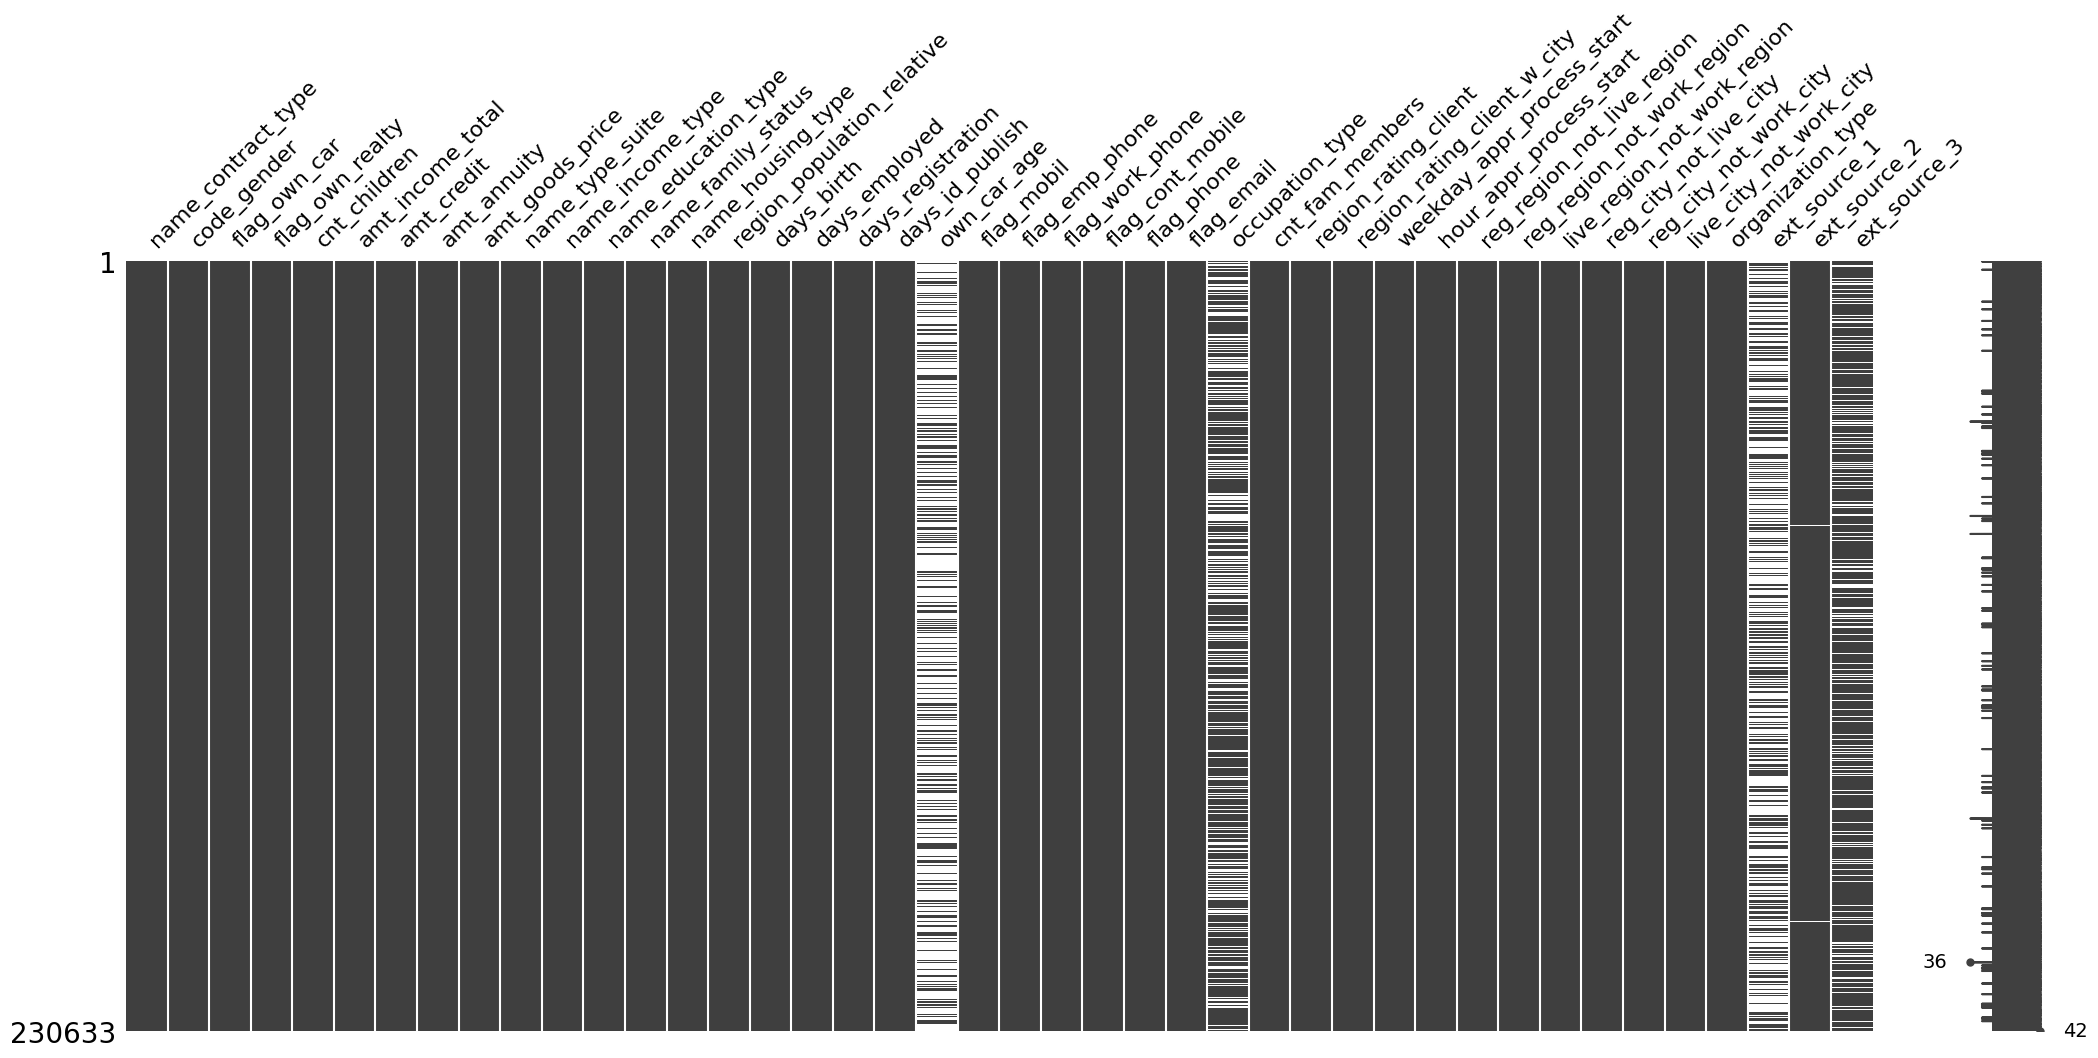

In [12]:
msno.matrix(app_df.iloc[:, :42])

Feature 44~90

<Axes: >

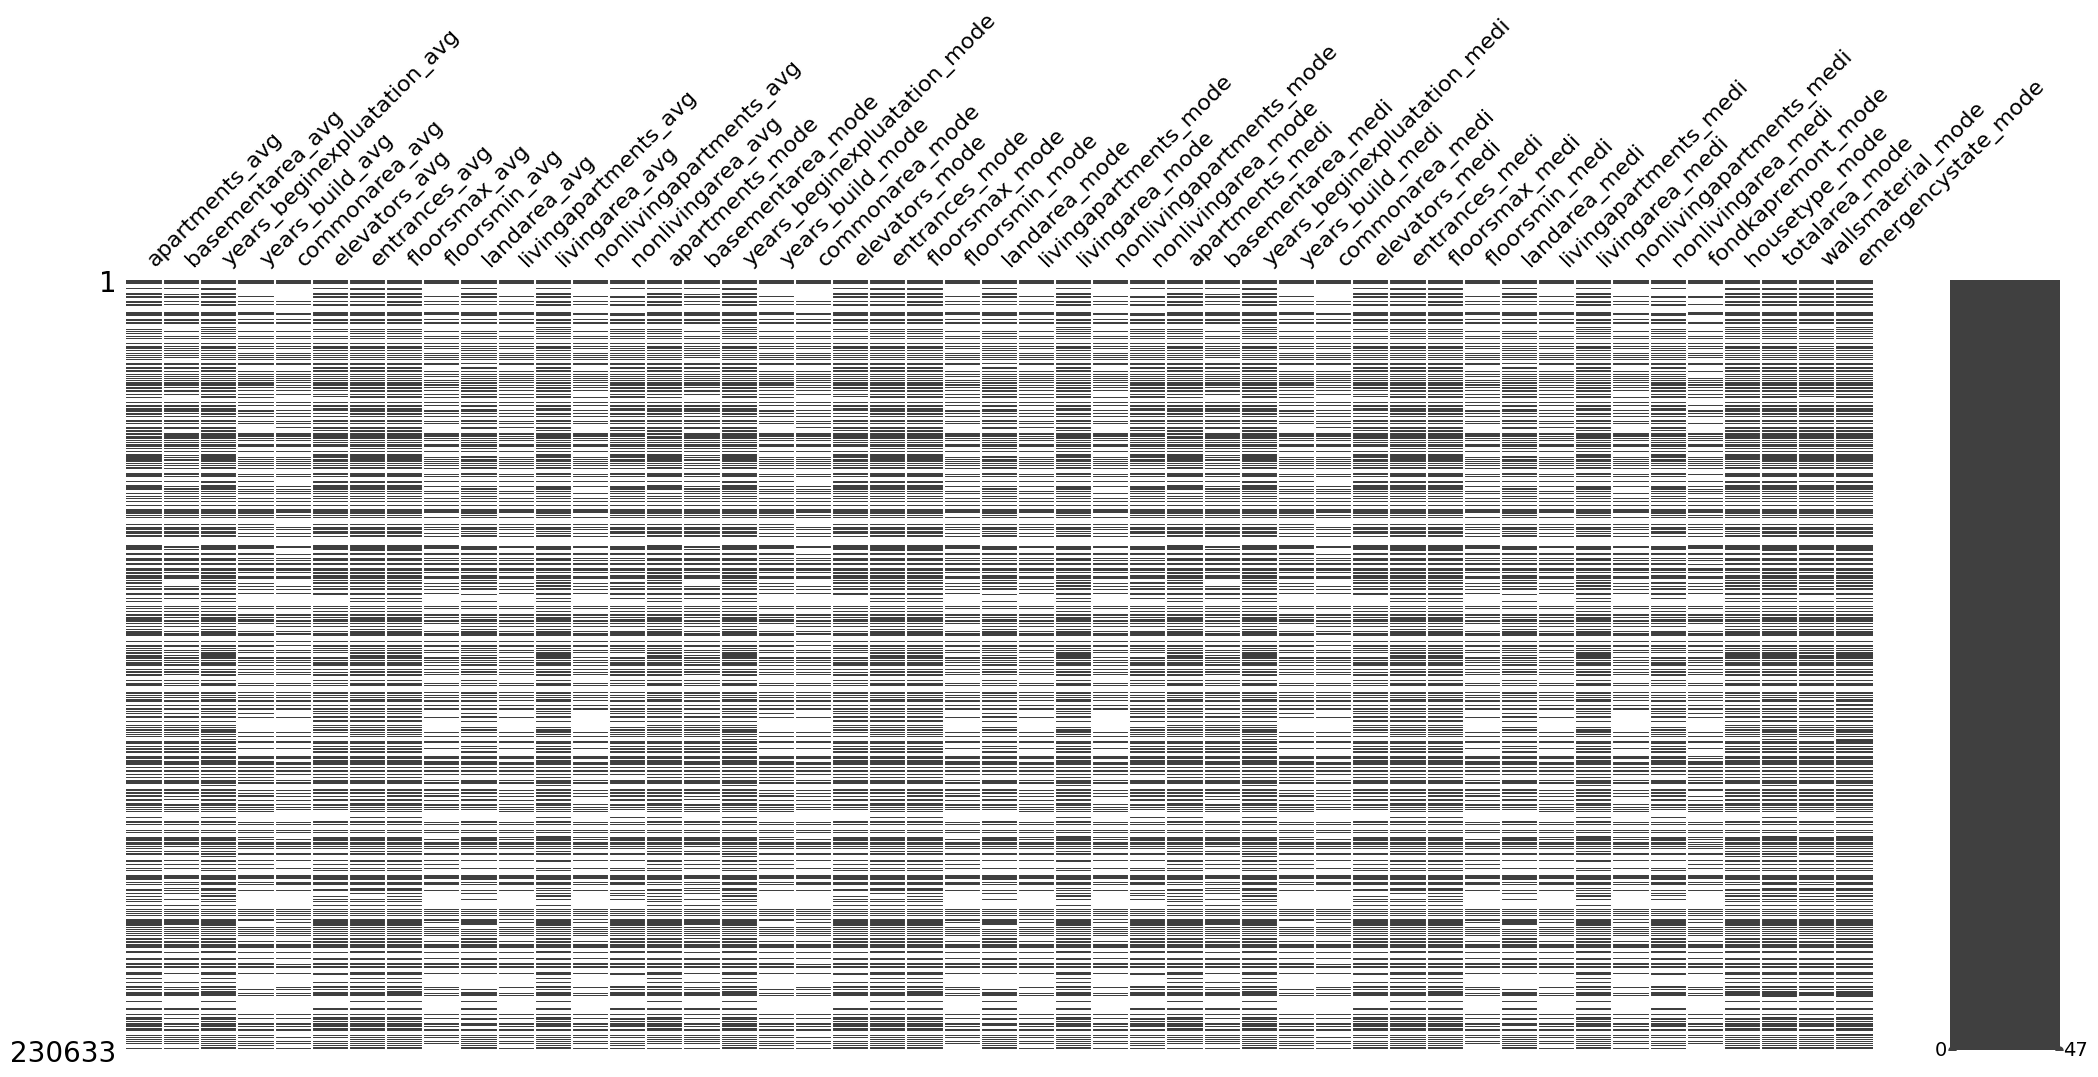

In [13]:
msno.matrix(app_df.iloc[:, 42:89])

These features are `residential_environment_stats` related, most of them have \
more than 60% of the data being null and many nulls occur simultaneously.

Feature 90~121

<Axes: >

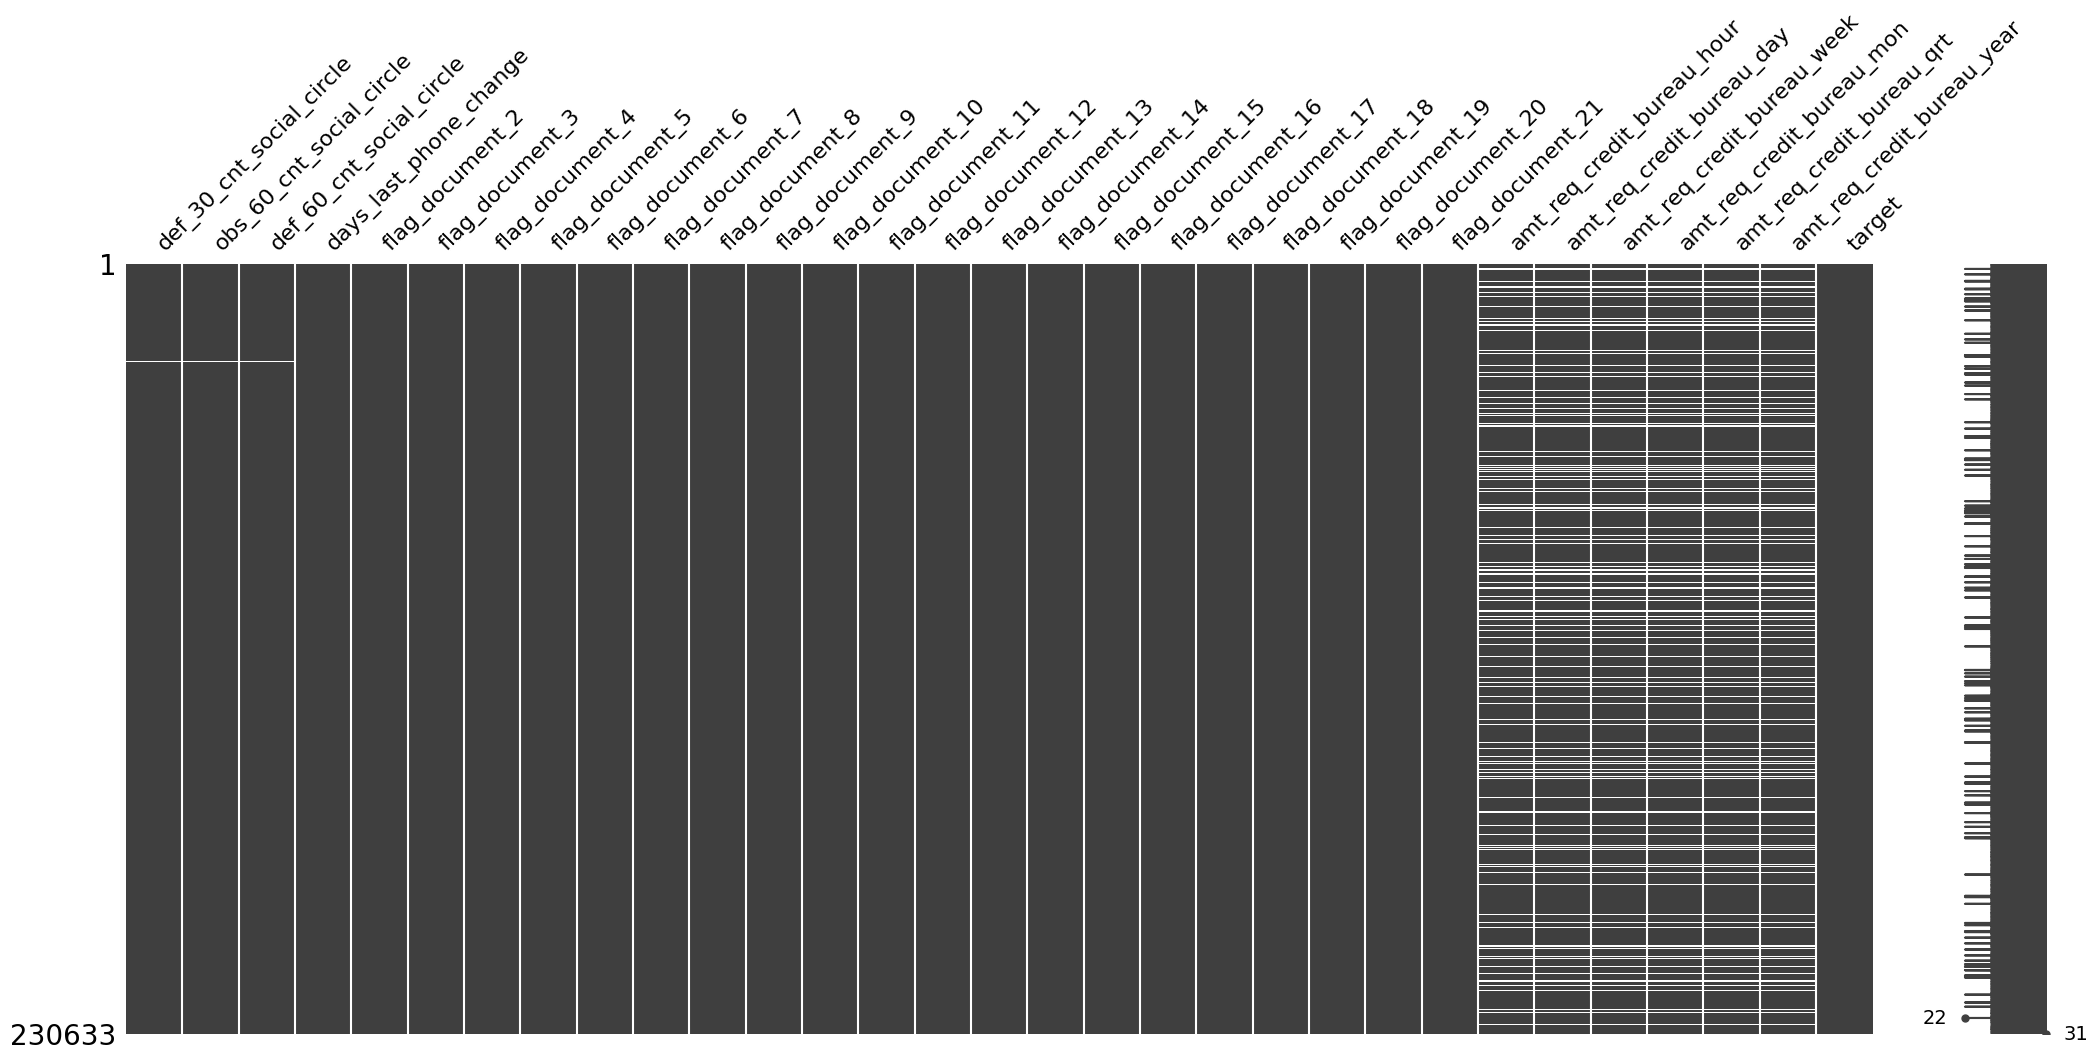

In [14]:
msno.matrix(app_df.iloc[:, 90:])

`social_circle` related, and `amt_req_credit_bureau` related features.

As amt_req_credit_bureau related features have already been imputed in the high \
impact features above, we won't look into them here.

Nulls that occurs simultaneously:

- __residential-environment related features__

- __social circle related features__ 

It is hard to use my domain knowledge to guess the values of these features, as \
they are residential and personal social circle related and there's no other \
relevant features in the dataset.

> create a new column for accumulated nulls count of `residential-environment` \
and `social_circle` related features. Leave imputation to model.

In [15]:
# res_env
res_env_cols = app_df.iloc[:, 42:89].columns.tolist()

res_env_nulls_acc_transformer = FlagNullTransformer(
    col_names=res_env_cols, should_acc=True, acc_col_name="res_env_null_acc"
)

res_env_imp = (
    "res_env",
    res_env_nulls_acc_transformer,
    res_env_cols,
)

# social_circle
social_circle_cols = [i for i in app_df.columns if "social_circle" in i]

social_circle_nulls_acc_transformer = FlagNullTransformer(
    col_names=social_circle_cols, should_acc=True, acc_col_name="social_circle_null_acc"
)

social_circle_imp = (
    "social_circle",
    social_circle_nulls_acc_transformer,
    social_circle_cols,
)

The rest of the nulls: 

In [16]:
app_nulls[
    [
        i
        for i in app_nulls.columns.tolist()
        if i
        not in amt_credit_bu_time_cols
        + res_env_cols
        + social_circle_cols
        + ["occupation_type"]
    ]
].T

,null_count
amt_annuity,7
amt_goods_price,204
name_type_suite,958
own_car_age,152192
cnt_fam_members,1
ext_source_1,130098
ext_source_2,492
ext_source_3,45780


##### __3. Impute on domain knowledge__

From the missing data above, we can make a good guess of nulls in `own_car_age`. \
Nulls might just mean that one has no car.

__own_car_age__

> fill the own_car_age with -1.

In [17]:
own_car_age_imp = (
    "own_car_age",
    SimpleImputer(strategy="constant", fill_value=-1),
    ["own_car_age"],
)

#### Imputation pipeline

In [18]:
app_imputer = ColumnTransformer(
    [
        own_car_age_imp,
        occupation_type_imp,
        res_env_imp,
        social_circle_imp,
        amt_credit_bu_time_imp,
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

dp(app_imputer)

ColumnTransformer(remainder='passthrough',
                  transformers=[('own_car_age',
                                 SimpleImputer(fill_value=-1,
                                               strategy='constant'),
                                 ['own_car_age']),
                                ('occupation_type',
                                 SimpleImputer(fill_value='no_job',
                                               strategy='constant'),
                                 ['occupation_type']),
                                ('res_env',
                                 FlagNullTransformer(acc_col_name='res_env_null_acc',
                                                     col_names=['apartments_avg',
                                                                'basementarea_avg',
                                                                'years_b...
                                                                'amt_req_credit_bureau_day',
                                                                'amt_req_credit_bureau_week',
                                                                'amt_req_credit_bureau_mon',
                                                                'amt_req_credit_bureau_qrt',
                                                                'amt_req_credit_bureau_year']),
                                 ['amt_req_credit_bureau_hour',
                                  'amt_req_credit_bureau_day',
                                  'amt_req_credit_bureau_week',
                                  'amt_req_credit_bureau_mon',
                                  'amt_req_credit_bureau_qrt',
                                  'amt_req_credit_bureau_year'])],
                  verbose_feature_names_out=False)

In [20]:
X_train = app_imputer.fit_transform(X_train)
X_val = app_imputer.transform(X_val)

In [21]:
joblib.dump(X_train, "data/imputed_X_train")
joblib.dump(X_val, "data/imputed_X_val")

['data/imputed_X_val']

In [22]:
bprint("newly added columns to label nulls in some features:")
[i for i in X_train.columns if "null" in i]


newly added columns to label nulls in some features:


['res_env_null_acc',
 'social_circle_null_acc',
 'amt_req_credit_bureau_hour_isnull',
 'amt_req_credit_bureau_day_isnull',
 'amt_req_credit_bureau_week_isnull',
 'amt_req_credit_bureau_mon_isnull',
 'amt_req_credit_bureau_qrt_isnull',
 'amt_req_credit_bureau_year_isnull']

((Adjust the app transformers after feature selection))

In [24]:
social_circle_cols = ["def_30_cnt_social_circle", "def_60_cnt_social_circle"]

social_circle_nulls_acc_transformer = FlagNullTransformer(
    col_names=social_circle_cols, should_acc=True, acc_col_name="social_circle_null_acc"
)

social_circle_imp = (
    "social_circle",
    social_circle_nulls_acc_transformer,
    social_circle_cols,
)

res_env_cols2 = [
    "years_build_avg",
    "entrances_avg",
    "apartments_mode",
    "years_build_medi",
    "totalarea_mode",
]

res_env_nulls_acc_transformer = FlagNullTransformer(
    col_names=res_env_cols2, should_acc=True, acc_col_name="res_env_null_acc"
)

res_env_imp = (
    "res_env",
    res_env_nulls_acc_transformer,
    res_env_cols2,
)

adjusted_app_df_transformer = ColumnTransformer(
    [
        occupation_type_imp,
        res_env_imp,
        social_circle_imp,
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

joblib.dump(adjusted_app_df_transformer, "data/models/adjusted_app_df_transformer2")

dp(adjusted_app_df_transformer)

ColumnTransformer(remainder='passthrough',
                  transformers=[('occupation_type',
                                 SimpleImputer(fill_value='no_job',
                                               strategy='constant'),
                                 ['occupation_type']),
                                ('res_env',
                                 FlagNullTransformer(acc_col_name='res_env_null_acc',
                                                     col_names=['years_build_avg',
                                                                'entrances_avg',
                                                                'apartments_mode',
                                                                'years_build_medi',
                                                                'totalarea_mode'],
                                                     should_acc=True),
                                 ['years_build_avg', 'entrances_avg',
                                  'apartments_mode', 'years_build_medi',
                                  'totalarea_mode']),
                                ('social_circle',
                                 FlagNullTransformer(acc_col_name='social_circle_null_acc',
                                                     col_names=['def_30_cnt_social_circle',
                                                                'def_60_cnt_social_circle'],
                                                     should_acc=True),
                                 ['def_30_cnt_social_circle',
                                  'def_60_cnt_social_circle'])],
                  verbose_feature_names_out=False)

Go to `2_clean_supporting_dfs` for the next part. 